# 1. Load Libraries

In [493]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from scipy.stats import uniform, randint

from joblib import dump

In [492]:
!pip install scipy

# 2. Load Data

In [5]:
df_loans = pd.read_csv(r"C:\Users\aravit01\OneDrive - Kearney\1. RAVI TEJA\12. My Learnings\Portfolio Projects to Showcase\Credit Default Model\loans.csv")
df_customer = pd.read_csv(r"C:\Users\aravit01\OneDrive - Kearney\1. RAVI TEJA\12. My Learnings\Portfolio Projects to Showcase\Credit Default Model\customers.csv")
df_buro = pd.read_csv(r"C:\Users\aravit01\OneDrive - Kearney\1. RAVI TEJA\12. My Learnings\Portfolio Projects to Showcase\Credit Default Model\bureau_data.csv")

In [7]:
df_loans.shape, df_customer.shape, df_buro.shape

((50000, 15), (50000, 12), (50000, 8))

In [8]:
df_loans.head(1)

,loan_id,cust_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
0,L00001,C00001,Auto,Secured,3004000,2467000,49340.0,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False


In [9]:
df_customer.head(1)

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001


In [10]:
df_buro.head(1)

,cust_id,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,1,1,42,0,0,3,7


## 2.1 Merge data

In [11]:
df = pd.merge(df_customer, df_loans, on = 'cust_id')
df.head()

# merge customer & loans to df

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001,L00001,Auto,Secured,3004000,2467000,49340.0,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,Tamil Nadu,600001,L00002,Home,Secured,4161000,3883000,77660.0,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,West Bengal,700001,L00003,Personal,Unsecured,2401000,2170000,43400.0,390600,1736000,21,1562399,1476042,2019-07-24,2019-08-21,False
3,C00004,55,F,Single,Self-Employed,3547000,1,Owned,15,Bangalore,Karnataka,560001,L00004,Personal,Unsecured,2345000,1747000,34940.0,314460,1397600,6,1257839,1031094,2019-07-24,2019-08-09,False
4,C00005,37,M,Married,Salaried,3432000,3,Owned,28,Pune,Maharashtra,411001,L00005,Auto,Secured,4647000,4520000,90400.0,813600,3616000,28,1772334,1032458,2019-07-24,2019-08-02,False


In [12]:
df = pd.merge(df, df_buro, on = 'cust_id')
df.head()

# merge df & buro as df

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001,L00001,Auto,Secured,3004000,2467000,49340.0,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False,1,1,42,0,0,3,7
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,Tamil Nadu,600001,L00002,Home,Secured,4161000,3883000,77660.0,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False,3,1,96,12,60,5,4
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,West Bengal,700001,L00003,Personal,Unsecured,2401000,2170000,43400.0,390600,1736000,21,1562399,1476042,2019-07-24,2019-08-21,False,2,1,82,24,147,6,58
3,C00004,55,F,Single,Self-Employed,3547000,1,Owned,15,Bangalore,Karnataka,560001,L00004,Personal,Unsecured,2345000,1747000,34940.0,314460,1397600,6,1257839,1031094,2019-07-24,2019-08-09,False,3,0,115,15,87,5,26
4,C00005,37,M,Married,Salaried,3432000,3,Owned,28,Pune,Maharashtra,411001,L00005,Auto,Secured,4647000,4520000,90400.0,813600,3616000,28,1772334,1032458,2019-07-24,2019-08-02,False,4,2,120,0,0,5,10


In [13]:
df.shape

# total we have (15+12+8 = 35 cols), since cust_id is common in all 3 df, minus 2
# total cols = 35-2 = 33cols

(50000, 33)

In [14]:
df.info()

# target feature is "default" which is bool


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cust_id                      50000 non-null  object 
 1   age                          50000 non-null  int64  
 2   gender                       50000 non-null  object 
 3   marital_status               50000 non-null  object 
 4   employment_status            50000 non-null  object 
 5   income                       50000 non-null  int64  
 6   number_of_dependants         50000 non-null  int64  
 7   residence_type               49938 non-null  object 
 8   years_at_current_address     50000 non-null  int64  
 9   city                         50000 non-null  object 
 10  state                        50000 non-null  object 
 11  zipcode                      50000 non-null  int64  
 12  loan_id                      50000 non-null  object 
 13  loan_purpose    

In [15]:
df['default'] = df['default'].astype('int')

# convert bool dtype  --> int dtype

In [17]:
df['default'].head()

0    0
1    0
2    0
3    0
4    0
Name: default, dtype: int32

In [16]:
df['default'].value_counts()

# distinctcount of values, clearly we observe there is class imbalance
# default 0 --> no/false
# default 1 --> yes/true

default
0    45703
1     4297
Name: count, dtype: int64

In [21]:
(4297/50000)

# 8.5% of values are in minority class
# 91.4% of values are in majority class

0.08594

# 2.2 split df to avoid data leakage

In [23]:
X = df.drop('default', axis = 1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# we split the data to handle data leakage & target leakage

In [24]:
df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

# we concat train & test set 

In [25]:
df_train.shape, df_test.shape

((37500, 33), (12500, 33))

# 3. Data Cleaning 

## 3.1 check for na values

In [27]:
df_train.isna().sum()

cust_id                         0
age                             0
gender                          0
marital_status                  0
employment_status               0
income                          0
number_of_dependants            0
residence_type                 48
years_at_current_address        0
city                            0
state                           0
zipcode                         0
loan_id                         0
loan_purpose                    0
loan_type                       0
sanction_amount                 0
loan_amount                     0
processing_fee                  0
gst                             0
net_disbursement                0
loan_tenure_months              0
principal_outstanding           0
bank_balance_at_application     0
disbursal_date                  0
installment_start_dt            0
number_of_open_accounts         0
number_of_closed_accounts       0
total_loan_months               0
delinquent_months               0
total_dpd     

In [28]:
df_train['residence_type'].value_counts()

residence_type
Owned       21114
Mortgage     8901
Rented       7437
Name: count, dtype: int64

In [29]:
df_train['residence_type'].unique()

# we observe NaN values, since NaN values are in permissed limit. we do imputation.
# since residence_type is categorical feature we use "mode" to fill NaN values

array(['Owned', 'Mortgage', 'Rented', nan], dtype=object)

## 3.2 data imputation

In [32]:
mode_residence = df_train['residence_type'].mode()[0]
mode_residence

'Owned'

In [33]:
df_train['residence_type'].fillna(mode_residence, inplace=True)

In [34]:
df_train['residence_type'].unique()

array(['Owned', 'Mortgage', 'Rented'], dtype=object)

In [35]:
df_test['residence_type'].fillna(mode_residence, inplace=True)

## 3.3 check for duplicates

In [37]:
df_train.duplicated().sum()

0

## 3.4 check for outliers

In [38]:
df_train.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default'],
      dtype='object')

In [42]:
df_train.select_dtypes(include=['int64', 'float64']).columns

Index(['age', 'income', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'sanction_amount', 'loan_amount', 'processing_fee', 'gst',
       'net_disbursement', 'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio'],
      dtype='object')

In [44]:
df_train.select_dtypes(include= 'object').columns

Index(['cust_id', 'gender', 'marital_status', 'employment_status',
       'residence_type', 'city', 'state', 'loan_id', 'loan_purpose',
       'loan_type', 'disbursal_date', 'installment_start_dt'],
      dtype='object')

In [43]:
columns_continuous = ['age', 'income', 'number_of_dependants', 'years_at_current_address',
        'sanction_amount', 'loan_amount', 'processing_fee', 'gst',
       'net_disbursement', 'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio']

In [45]:
columns_categorical = ['gender', 'marital_status', 'employment_status',
       'residence_type', 'city', 'state', 'zipcode', 'loan_purpose',
       'loan_type', 'default']

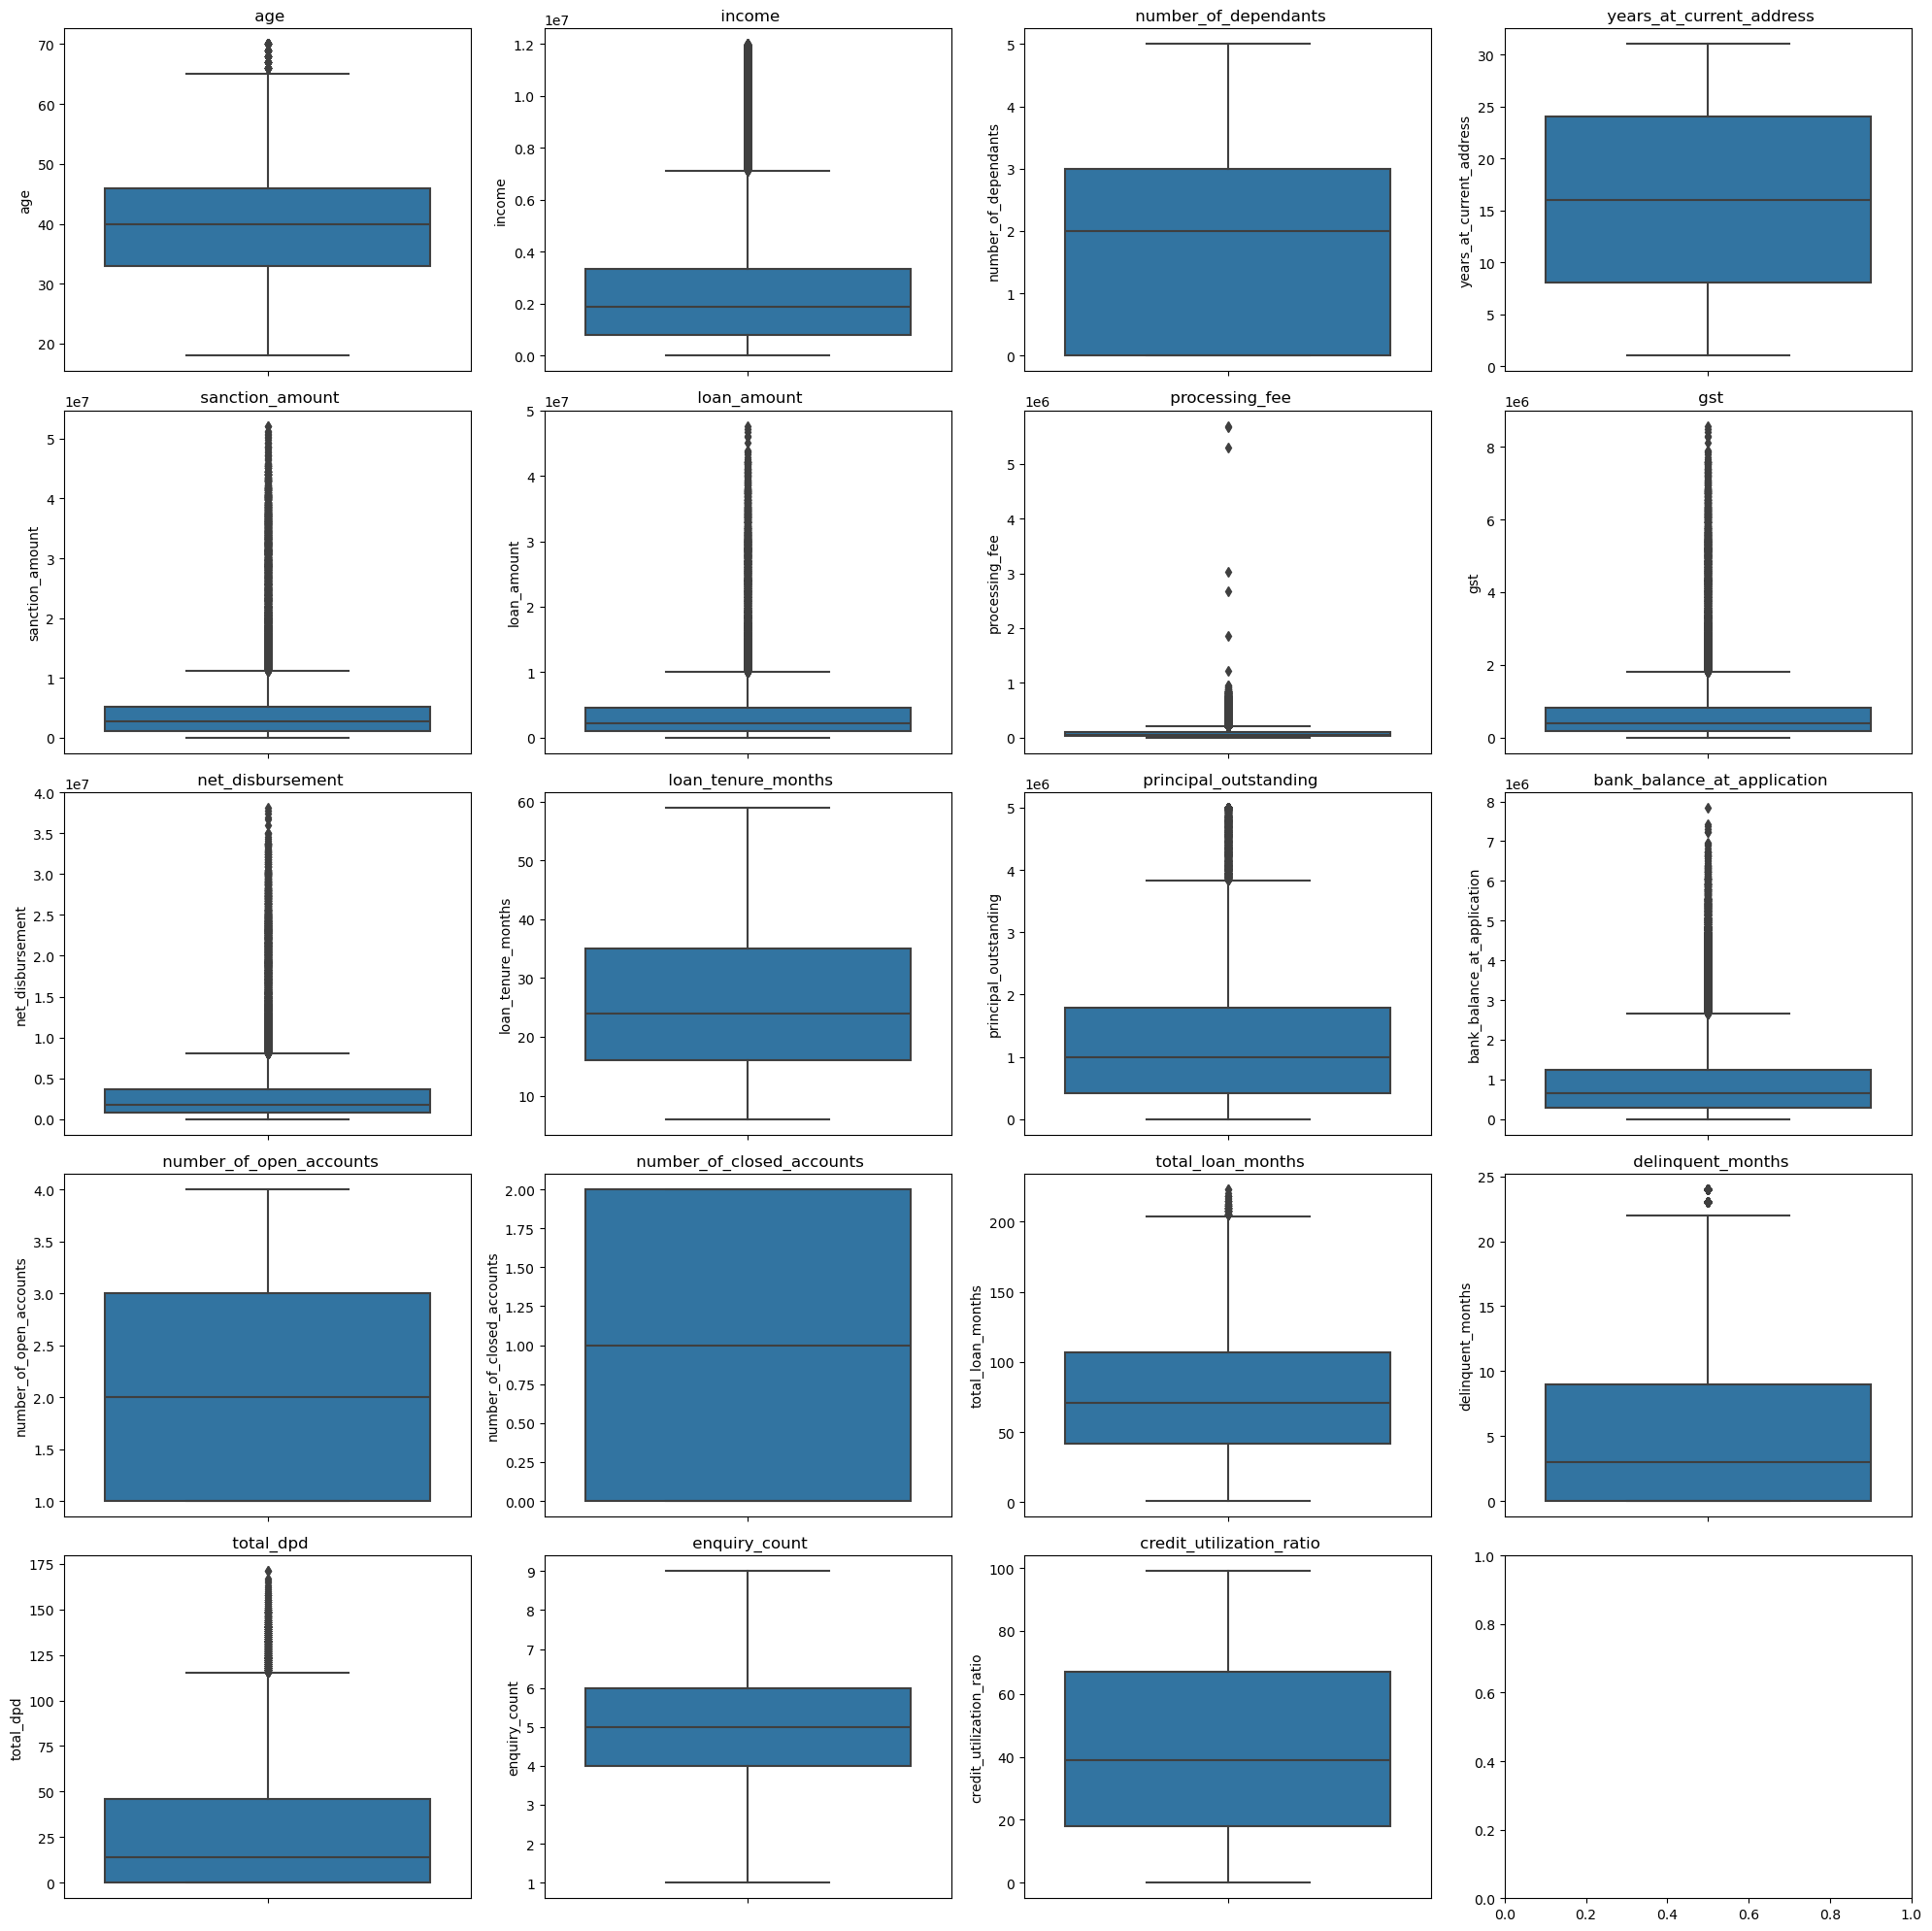

In [57]:
fig, axes = plt.subplots(5, 4, figsize = (20,20))

axes = axes.flatten()

for i, cols in enumerate(columns_continuous):
    sns.boxplot(data = df_train, y = cols, ax = axes[i])
    axes[i].set_title(f" {cols}")

plt.tight_layout()
plt.show()

# processing_fee seems to have outliers 
# gst seems to have outliers
# we would like to analysis further on processing_fee & gst

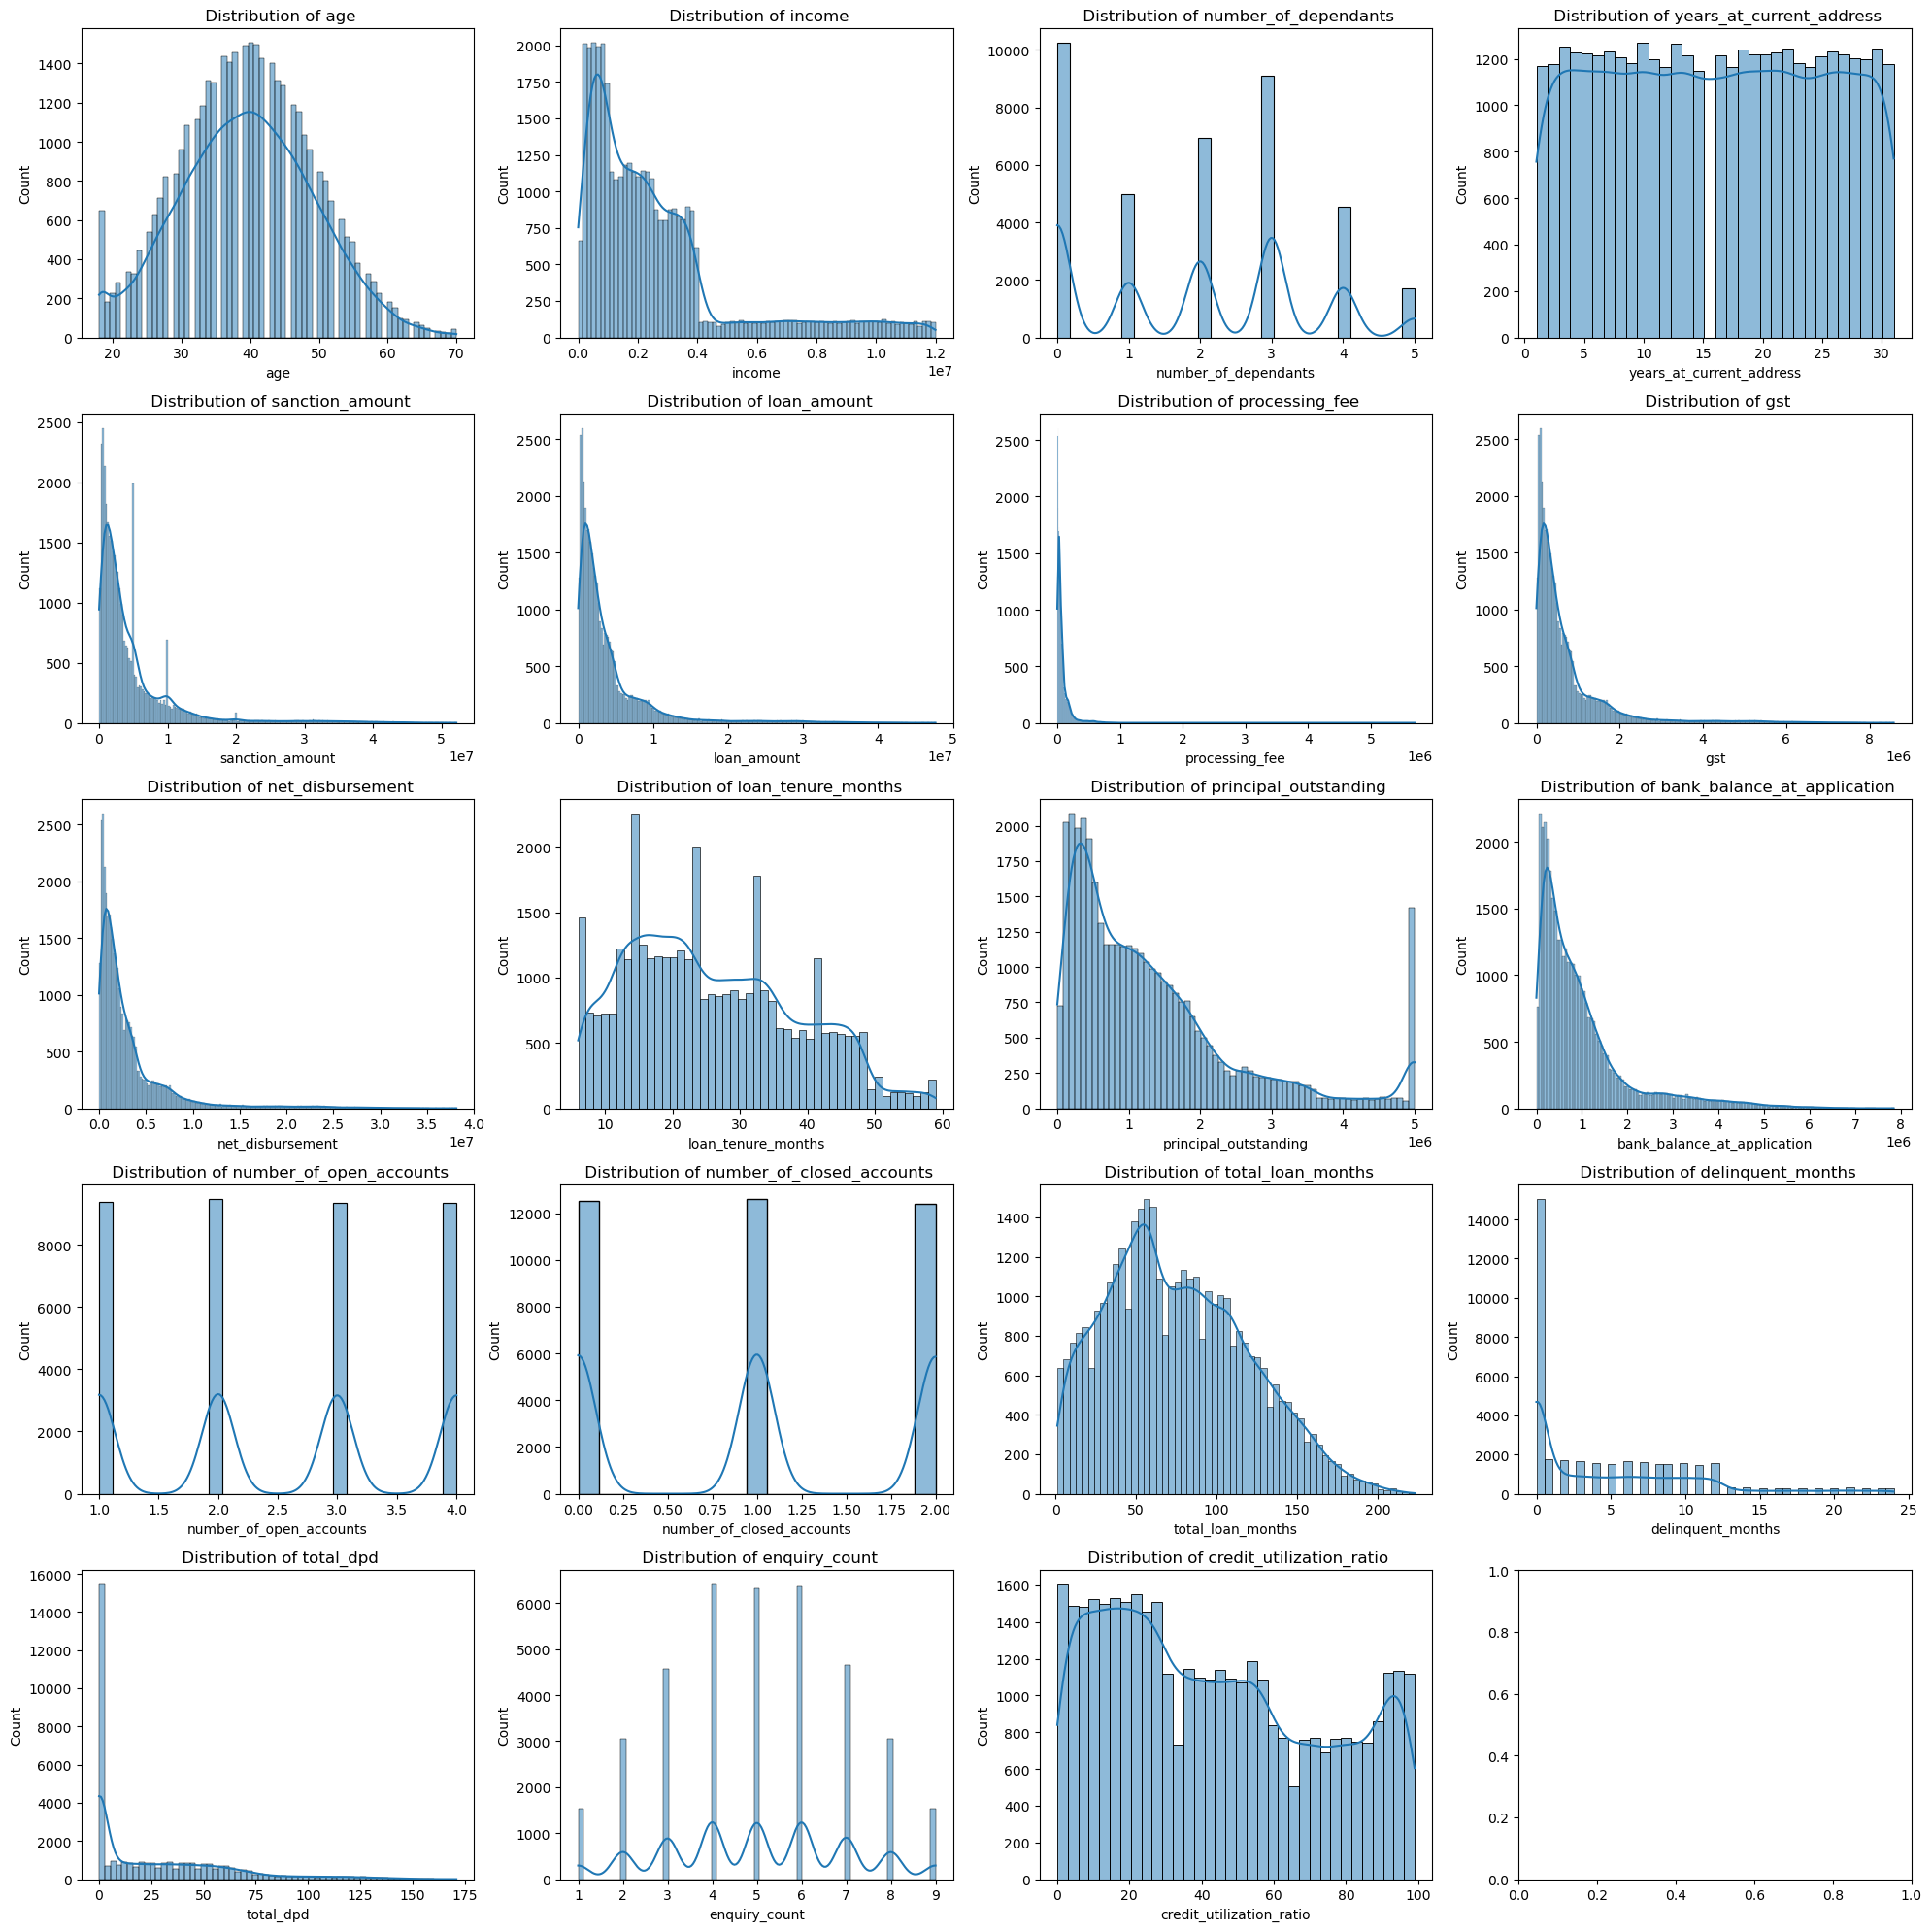

In [63]:
fig, axes = plt.subplots(5, 4, figsize = (20,20))

axes = axes.flatten()

for i, cols in enumerate(columns_continuous):
    sns.histplot(data = df_train, x = cols,kde = True, ax = axes[i])
    axes[i].set_title(f" Distribution of {cols}")

plt.tight_layout()
plt.show()

# age is normally distributed
# income is right skewed as excepted
# sanction_amt, laon_amt, processing_fee, gst, net_disbursement are more skewed in one direction, which might have potential data issues,
# which needs to be analyized


In [67]:
df_train['processing_fee'].describe()

count    3.750000e+04
mean     8.072411e+04
std      1.208307e+05
min      0.000000e+00
25%      1.918000e+04
50%      4.470000e+04
75%      9.200000e+04
max      5.698030e+06
Name: processing_fee, dtype: float64

In [76]:
df_train[df_train['processing_fee'] == df_train['processing_fee'].max()][['loan_amount', 'processing_fee']]

# here processing_fee > loan_amount

,loan_amount,processing_fee
12294,4639000,5.698030e+06


In [88]:
df_train[ (df_train['processing_fee'] / df_train['loan_amount']) >  0.03 ][['loan_amount', 'processing_fee']]

# we found outliers using above condition

,loan_amount,processing_fee
23981,2234000,2.669791e+06
9898,3626000,5.293544e+06
47089,1738000,1.858965e+06
33705,3812000,5.678021e+06
12294,4639000,5.698030e+06
28174,966000,1.214493e+06
29305,2616000,3.036378e+06


In [208]:
df_train1 = df_train[ (df_train['processing_fee'] / df_train['loan_amount']) <  0.03 ].copy()

# we negated condition & done deep copy into new df

In [209]:
df_train1[ (df_train1['processing_fee'] / df_train1['loan_amount']) >  0.03 ][['loan_amount', 'processing_fee']]

# tested with outlier condition, we observe, no outliers found 

,loan_amount,processing_fee


In [210]:
df_test = df_test[ (df_test['processing_fee'] / df_test['loan_amount']) <  0.03 ].copy()
df_test.shape

# same transformation is applied in test dataset as well

(12498, 34)

In [211]:
columns_categorical

['gender',
 'marital_status',
 'employment_status',
 'residence_type',
 'city',
 'state',
 'zipcode',
 'loan_purpose',
 'loan_type',
 'default']

In [212]:
for i in columns_categorical:
    print(f"{i}-->{df_train1[i].unique()} \n")

# there is issue with loan_purpose 'Personaal' --> 'Personal'

gender-->['F' 'M'] 

marital_status-->['Single' 'Married'] 

employment_status-->['Salaried' 'Self-Employed'] 

residence_type-->['Owned' 'Mortgage' 'Rented'] 

city-->['Ahmedabad' 'Delhi' 'Lucknow' 'Bangalore' 'Jaipur' 'Hyderabad' 'Kolkata'
 'Pune' 'Chennai' 'Mumbai'] 

state-->['Gujarat' 'Delhi' 'Uttar Pradesh' 'Karnataka' 'Rajasthan' 'Telangana'
 'West Bengal' 'Maharashtra' 'Tamil Nadu'] 

zipcode-->[380001 110001 226001 560001 302001 500001 700001 411001 600001 400001] 

loan_purpose-->['Home' 'Auto' 'Personal' 'Education' 'Personaal'] 

loan_type-->['Secured' 'Unsecured'] 

default-->[0 1] 



In [213]:
for i in columns_categorical:
    print(f"{i}-->{df_train1[i].nunique()} \n")

gender-->2 

marital_status-->2 

employment_status-->2 

residence_type-->3 

city-->10 

state-->9 

zipcode-->10 

loan_purpose-->5 

loan_type-->2 

default-->2 



In [214]:
df_train1['loan_purpose'] = df_train1['loan_purpose'].replace('Personaal', 'Personal')

In [215]:
df_test['loan_purpose'] = df_test['loan_purpose'].replace('Personaal', 'Personal')

In [216]:
df_train1['loan_purpose'].unique()

array(['Home', 'Auto', 'Personal', 'Education'], dtype=object)

In [217]:
df_train1[(df_train1['gst'] / df_train1['loan_amount']) > 0.20]

# condition for gst --> gst > 20%

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,default


In [218]:
df_train1[(df_train1['sanction_amount'] < df_train1['loan_amount'])]

# condition for sanction_amount --> sanction_amount > loan_amount

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,default


# 4. Exploratory Data Analysis

In [219]:
columns_continuous

['age',
 'income',
 'number_of_dependants',
 'years_at_current_address',
 'sanction_amount',
 'loan_amount',
 'processing_fee',
 'gst',
 'net_disbursement',
 'loan_tenure_months',
 'principal_outstanding',
 'bank_balance_at_application',
 'number_of_open_accounts',
 'number_of_closed_accounts',
 'total_loan_months',
 'delinquent_months',
 'total_dpd',
 'enquiry_count',
 'credit_utilization_ratio']

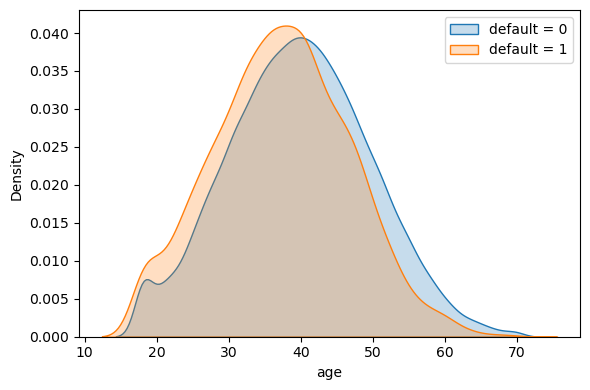

In [220]:
plt.figure(figsize = (6,4))

sns.kdeplot(data = df_train1[df_train1['default'] == 0], x = 'age', fill = True, label = "default = 0")
sns.kdeplot(data = df_train1[df_train1['default'] == 1], x = 'age', fill = True, label = "default = 1")

plt.legend()
plt.tight_layout()
plt.show()

# orange graph shifts left compared with blue graph, means likelyhood of young age defaulters compared with non-defaulters 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


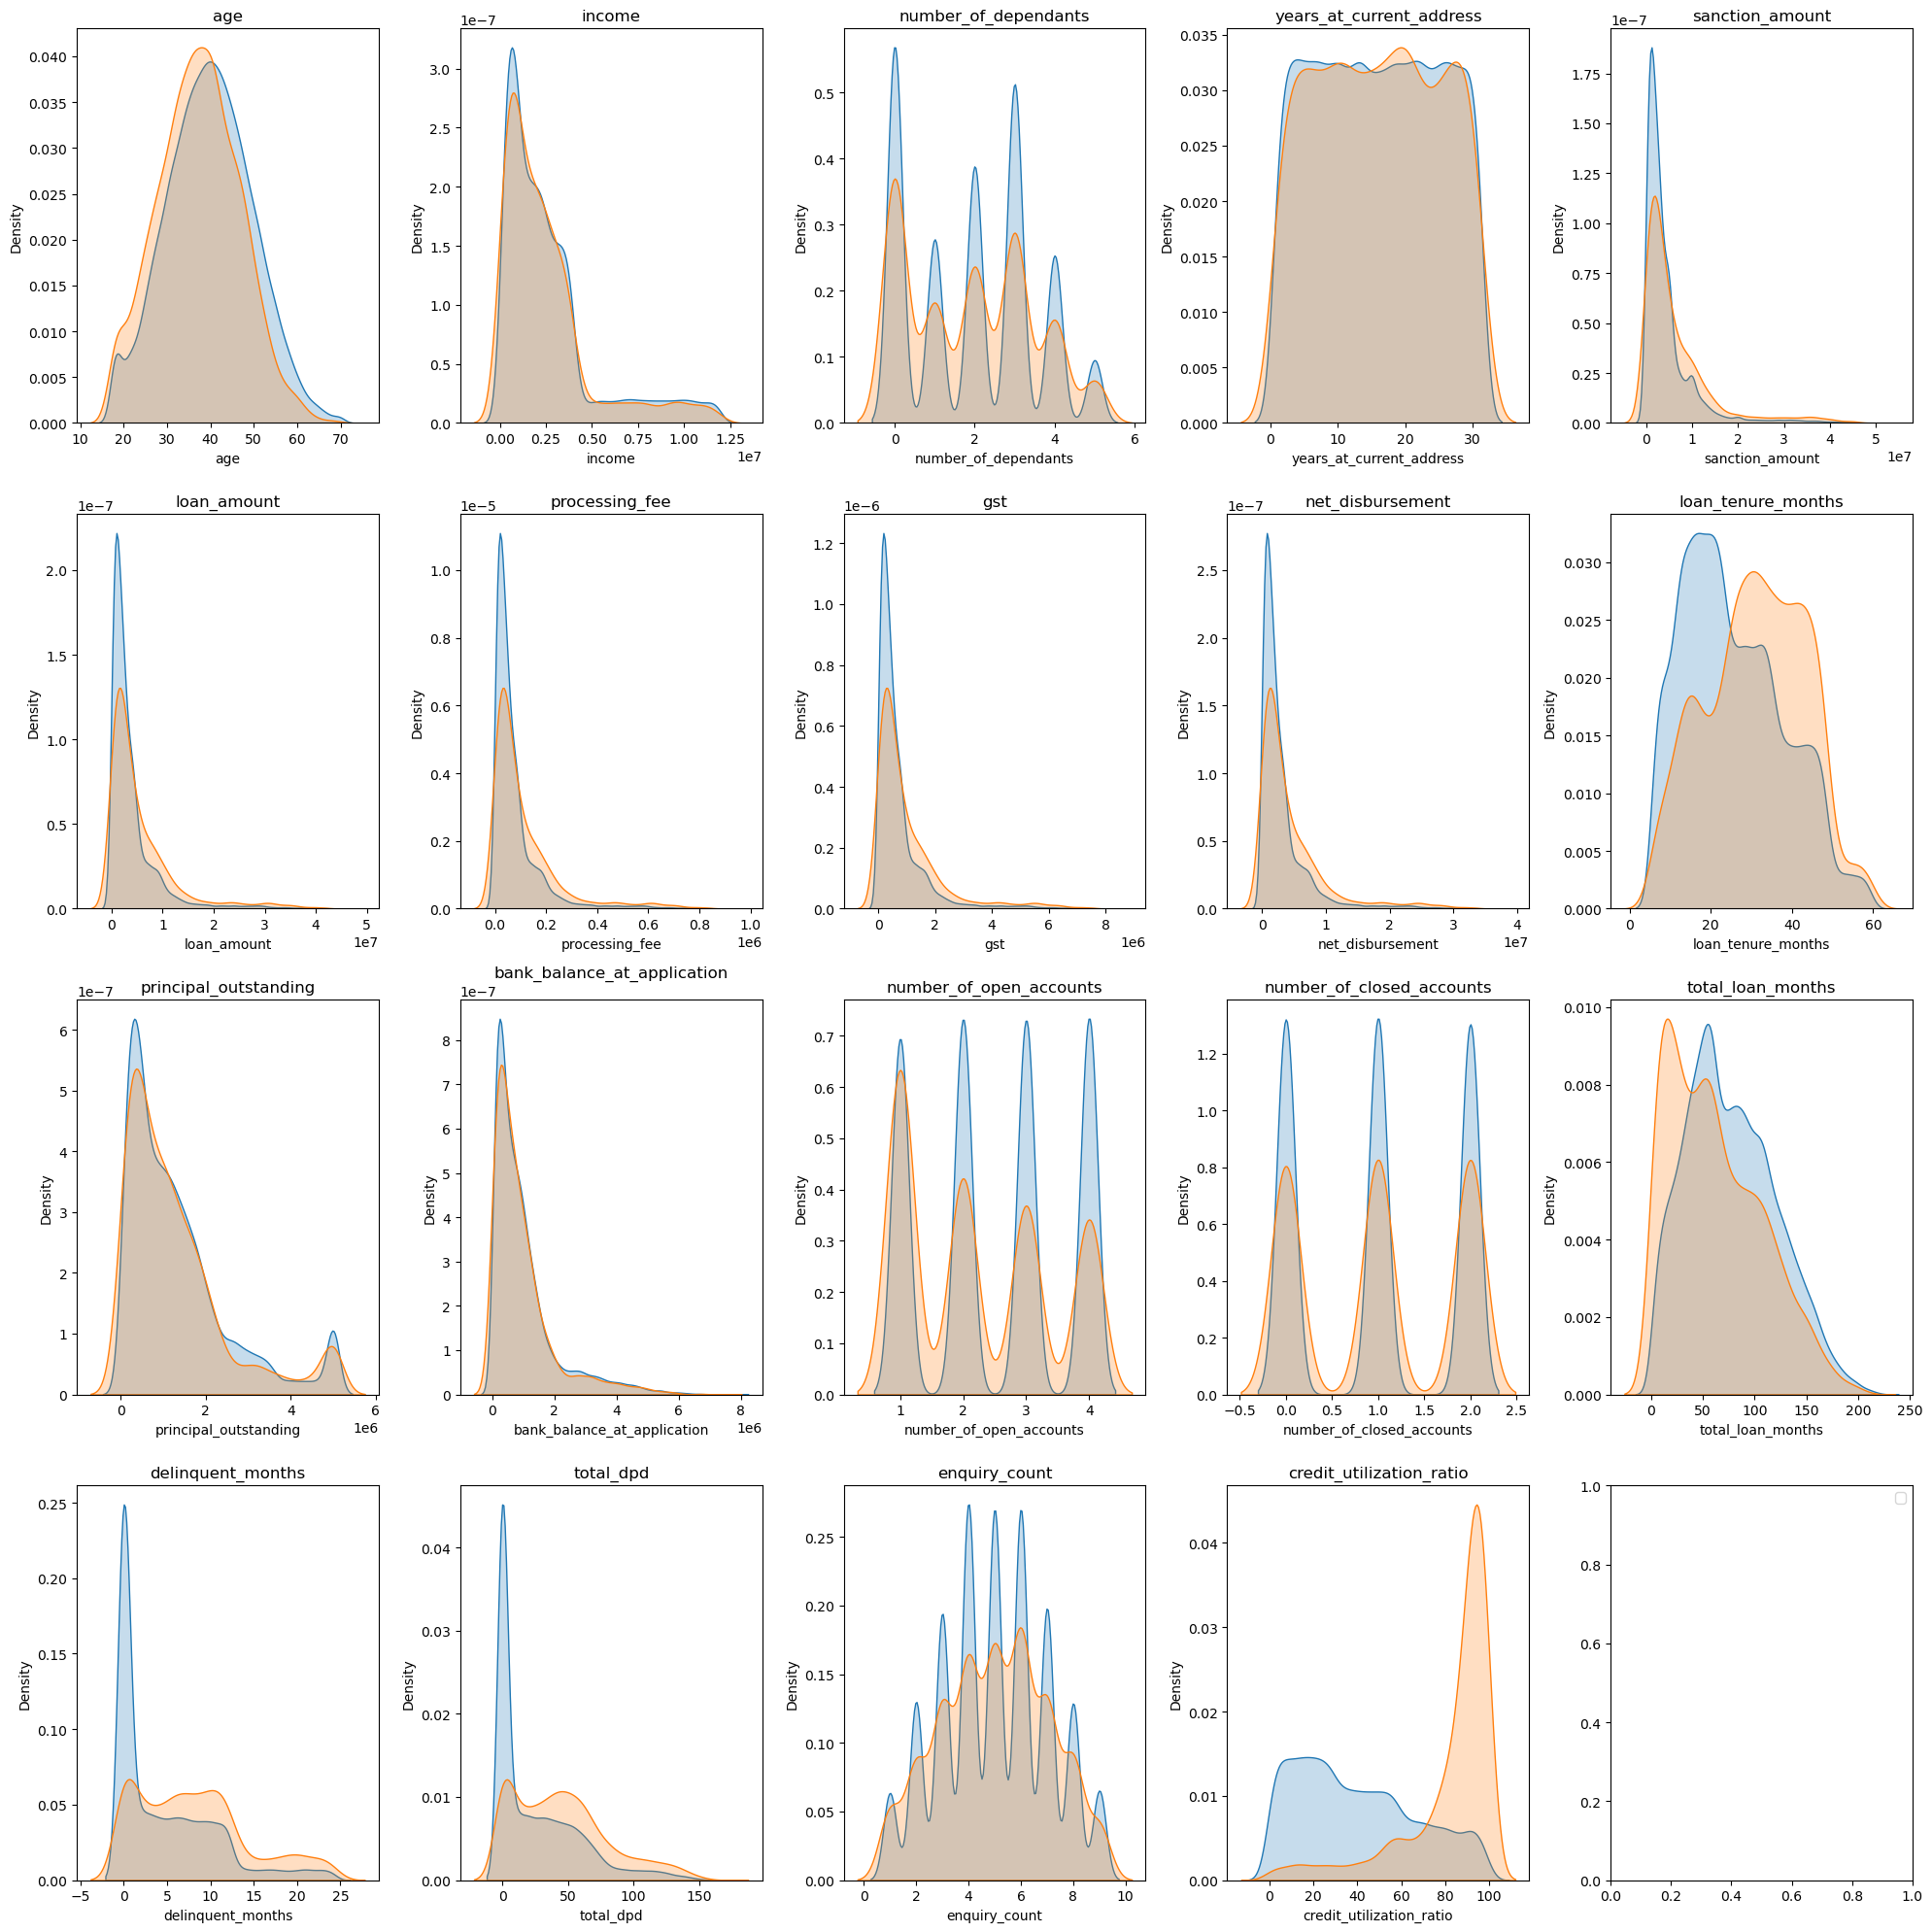

In [221]:
fig, axes = plt.subplots(4,5, figsize = (20,20))

axes = axes.flatten()

for i, cols in enumerate(columns_continuous):
    sns.kdeplot(data = df_train1[df_train1['default'] == 0], x = cols, ax = axes[i], fill = True, label = 'default 0')
    sns.kdeplot(data = df_train1[df_train1['default'] == 1], x = cols, ax = axes[i], fill = True, label = 'default 1')
    axes[i].set_title(f"{cols}")

plt.legend()
plt.tight_layout()
plt.show()

# - Younger individuals are more likely to default compared to older individuals.
# - A higher credit utilization ratio increases the likelihood of default.
# - When the total DPD (days past due) is low, the likelihood of default is lower.
# - Fewer delinquent months suggest a lower likelihood of default.

# 5 feature Engineering

In [222]:
df_train1['loan_to_income'] = round((df_train1['loan_amount'] / df_train1['income']),2)
df_train1['loan_to_income'].describe()

# adding new feature ('loan_to_income') as per business need 

count    37487.000000
mean         1.554890
std          0.972907
min          0.300000
25%          0.770000
50%          1.160000
75%          2.450000
max          4.570000
Name: loan_to_income, dtype: float64

In [223]:
df_test['loan_to_income'] = round((df_test['loan_amount'] / df_test['income']),2)


In [224]:
df_train1['loan_to_income']

27434    2.90
13400    1.08
883      0.66
7303     1.10
45124    1.84
         ... 
11284    1.36
44732    1.36
38158    2.71
860      1.50
15795    0.78
Name: loan_to_income, Length: 37487, dtype: float64

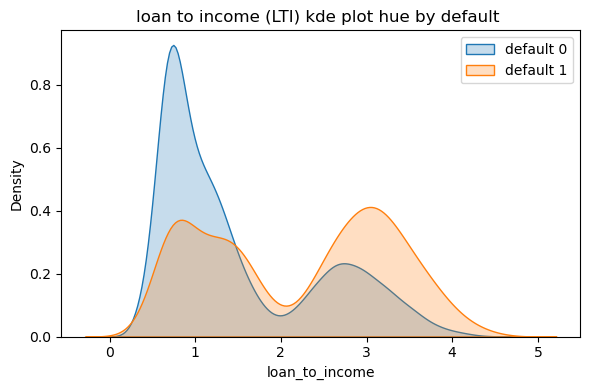

In [225]:
plt.figure(figsize=(6,4))

sns.kdeplot(data = df_train1[df_train1['default'] == 0], x = 'loan_to_income', fill = True, label = 'default 0')
sns.kdeplot(data = df_train1[df_train1['default'] == 1], x = 'loan_to_income', fill = True, label = 'default 1')
plt.title(f"loan to income (LTI) kde plot hue by default ")

plt.legend()
plt.tight_layout()
plt.show()



In [226]:
df_train1[['delinquent_months', 'total_loan_months']].head(3)

,delinquent_months,total_loan_months
27434,6,90
13400,4,119
883,14,83


In [227]:
df_train1['delinquency_ratio'] = round(df_train1['delinquent_months'] * 100 / df_train1['total_loan_months'],2)
df_train1[['delinquent_months', 'total_loan_months', 'delinquency_ratio']].head(2)

# adding new feature ('delinquency_ratio') as per business need 

,delinquent_months,total_loan_months,delinquency_ratio
27434,6,90,6.67
13400,4,119,3.36


In [228]:
df_test['delinquency_ratio'] = round(df_test['delinquent_months'] * 100 / df_test['total_loan_months'],2)
df_test[['delinquent_months', 'total_loan_months', 'delinquency_ratio']].head(2)

# same transformation for test dataset. 

,delinquent_months,total_loan_months,delinquency_ratio
33553,3,70,4.29
9427,0,115,0.00


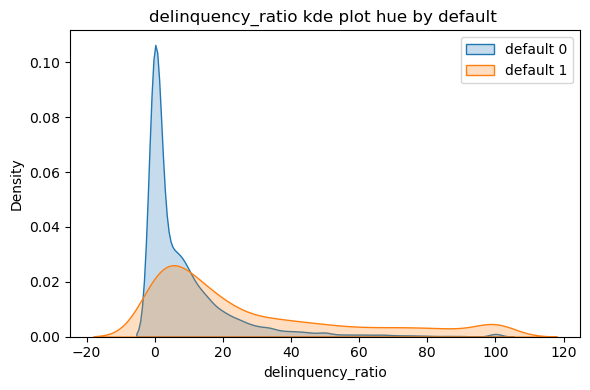

In [229]:
plt.figure(figsize=(6,4))

sns.kdeplot(data = df_train1[df_train1['default'] == 0], x = 'delinquency_ratio', fill = True, label = 'default 0')
sns.kdeplot(data = df_train1[df_train1['default'] == 1], x = 'delinquency_ratio', fill = True, label = 'default 1')
plt.title(f"delinquency_ratio kde plot hue by default ")

plt.legend()
plt.tight_layout()
plt.show()

# when delinquency_ratio is low likelyhood of default is low

In [230]:
df_train1['avg_dpb_per_delinquency'] = (df_train1['total_dpd'] / df_train1['delinquent_months']).round(1)
df_train1['avg_dpb_per_delinquency'].describe()

count    22474.000000
mean         5.495119
std          1.402161
min          1.000000
25%          4.800000
50%          5.500000
75%          6.200000
max         10.000000
Name: avg_dpb_per_delinquency, dtype: float64

In [231]:
df_train1['avg_dpb_per_delinquency'].isna().sum()

# we observe, there are lot of NaN values, this happens mainly because "delinquent_months" can be zero
# to handle this we use np.where

15013

In [232]:
df_train1['avg_dpb_per_delinquency'] = np.where(df_train1['delinquent_months'] !=0, (df_train1['total_dpd'] / df_train1['delinquent_months']),0).round(1)

In [233]:
df_test['avg_dpb_per_delinquency'] = np.where(df_test['delinquent_months'] !=0, (df_test['total_dpd'] / df_test['delinquent_months']),0).round(1)

In [234]:
df_train1['avg_dpb_per_delinquency'].describe()

count    37487.000000
mean         3.294403
std          2.903256
min          0.000000
25%          0.000000
50%          4.300000
75%          5.800000
max         10.000000
Name: avg_dpb_per_delinquency, dtype: float64

In [235]:
df_train1['avg_dpb_per_delinquency'].isna().sum()

0

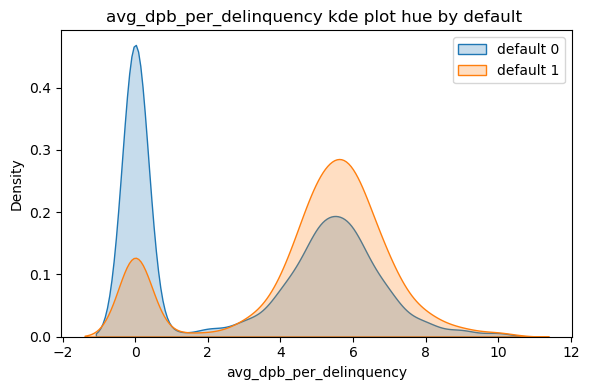

In [236]:
plt.figure(figsize=(6,4))

sns.kdeplot(data = df_train1[df_train1['default'] == 0], x = 'avg_dpb_per_delinquency', fill = True, label = 'default 0')
sns.kdeplot(data = df_train1[df_train1['default'] == 1], x = 'avg_dpb_per_delinquency', fill = True, label = 'default 1')
plt.title(f"avg_dpb_per_delinquency kde plot hue by default ")

plt.legend()
plt.tight_layout()
plt.show()

In [237]:
df_train1.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default',
       'loan_to_income', 'delinquency_ratio', 'avg_dpb_per_delinquency'],
      dtype='object')

## 5.1 feature selection using Variance Inflation Factor (VIF)

In [240]:
df_train2 = df_train1.drop(['cust_id','loan_id'], axis=1)

In [241]:
df_train3 = df_train2.drop(['disbursal_date','installment_start_dt','income','sanction_amount',
                'loan_amount','total_loan_months', 'delinquent_months','total_dpd'], axis=1)

# after discussion with business we dropped above columns

In [242]:
df_test = df_test.drop(['disbursal_date','installment_start_dt','income','sanction_amount',
                'loan_amount','total_loan_months', 'delinquent_months','total_dpd'], axis=1)

# same transformation is applied to test dataset

In [243]:
df_train3.columns

Index(['age', 'gender', 'marital_status', 'employment_status',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'loan_purpose', 'loan_type',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'default', 'loan_to_income',
       'delinquency_ratio', 'avg_dpb_per_delinquency'],
      dtype='object')

In [244]:
df_train3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37487 entries, 27434 to 15795
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          37487 non-null  int64  
 1   gender                       37487 non-null  object 
 2   marital_status               37487 non-null  object 
 3   employment_status            37487 non-null  object 
 4   number_of_dependants         37487 non-null  int64  
 5   residence_type               37487 non-null  object 
 6   years_at_current_address     37487 non-null  int64  
 7   city                         37487 non-null  object 
 8   state                        37487 non-null  object 
 9   zipcode                      37487 non-null  int64  
 10  loan_purpose                 37487 non-null  object 
 11  loan_type                    37487 non-null  object 
 12  processing_fee               37487 non-null  float64
 13  gst              

In [251]:
df_train3.select_dtypes(include=['int64', 'float64']).columns

# these are columns which VIF is calculated to find Multicollinearity
# This is because VIF measures how much the variance of a numerical feature is inflated due to its linear relationship with other numerical features.
# relies on regression techniques
# for VIF, all numerical features needs to be scaled


Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpb_per_delinquency'],
      dtype='object')

In [252]:
X_train = df_train3.drop('default', axis = 1)
y_train = df_train3['default']

cols_to_scale = df_train3.select_dtypes(include=['int64', 'float64']).columns

scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

In [257]:
X_train.head()

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,loan_purpose,loan_type,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpb_per_delinquency
27434,0.519231,F,Single,Salaried,0.0,Owned,0.133333,Ahmedabad,Gujarat,0.457627,Home,Secured,0.067749,0.067749,0.067749,0.339623,0.175096,0.069846,1.000000,1.0,0.875,0.595960,0.608899,0.0667,0.55
13400,0.211538,M,Single,Salaried,0.0,Owned,0.800000,Delhi,Delhi,0.000000,Auto,Secured,0.052292,0.052292,0.052292,0.509434,0.195995,0.119061,0.666667,0.5,0.375,0.929293,0.182670,0.0336,0.42
883,0.615385,F,Single,Self-Employed,0.0,Mortgage,0.933333,Lucknow,Uttar Pradesh,0.196610,Personal,Unsecured,0.039272,0.039272,0.039272,0.245283,0.271233,0.096133,0.333333,0.5,0.375,0.838384,0.084309,0.1687,0.56
7303,0.480769,F,Single,Self-Employed,0.2,Owned,0.866667,Bangalore,Karnataka,0.762712,Auto,Secured,0.005208,0.005208,0.005208,0.283019,0.026998,0.012511,0.000000,0.5,0.500,0.343434,0.187354,0.0000,0.00
45124,0.250000,F,Single,Salaried,0.0,Owned,0.866667,Jaipur,Rajasthan,0.325424,Education,Secured,0.004410,0.004410,0.004410,0.735849,0.007257,0.006171,0.333333,0.0,0.500,0.191919,0.360656,0.0968,0.47


In [258]:
X_train.shape

(37487, 25)

In [256]:
X_train.describe()

# after scaling, all feature should have min_value 0 & max_value = 1

,age,number_of_dependants,years_at_current_address,zipcode,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpb_per_delinquency
count,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000
mean,0.414681,0.388476,0.499787,0.523326,0.083030,0.083030,0.083030,0.375431,0.261931,0.123683,0.498795,0.498386,0.500410,0.437656,0.293885,0.103945,0.329440
std,0.189510,0.307163,0.297939,0.286165,0.113437,0.113437,0.113437,0.234410,0.244515,0.133507,0.372407,0.407528,0.252997,0.296517,0.227847,0.172686,0.290326
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.288462,0.000000,0.233333,0.325424,0.019100,0.019100,0.019100,0.188679,0.078179,0.034088,0.000000,0.000000,0.375000,0.181818,0.110070,0.000000,0.000000
50%,0.423077,0.400000,0.500000,0.491525,0.045887,0.045887,0.045887,0.339623,0.194385,0.082720,0.333333,0.500000,0.500000,0.393939,0.201405,0.038000,0.430000
75%,0.538462,0.600000,0.766667,0.762712,0.095512,0.095512,0.095512,0.547170,0.353152,0.155525,0.666667,1.000000,0.625000,0.676768,0.503513,0.131100,0.580000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [259]:
X_test = df_test.drop('default', axis = 1)
y_test = df_test['default']


X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [260]:
X_test.describe()

# after scaling, all feature should have min_value 0 & max_value = 1

,age,number_of_dependants,years_at_current_address,zipcode,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,delinquency_ratio,loan_to_income,avg_dpb_per_delinquency
count,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000
mean,0.413678,0.386174,0.503088,0.525588,0.082764,0.082764,0.082764,0.378690,0.263201,0.124546,0.503681,0.506961,0.503471,0.439030,0.104142,0.294318,0.330698
std,0.189011,0.306940,0.296372,0.287152,0.111372,0.111372,0.111372,0.235128,0.245299,0.134018,0.374460,0.405600,0.255602,0.296583,0.173989,0.226731,0.290731
min,0.000000,0.000000,0.000000,0.000000,0.000126,0.000126,0.000126,0.000000,-0.000163,0.000216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.288462,0.000000,0.233333,0.325424,0.019725,0.019725,0.019725,0.188679,0.078853,0.034518,0.000000,0.000000,0.375000,0.181818,0.000000,0.110070,0.000000
50%,0.423077,0.400000,0.500000,0.510169,0.046244,0.046244,0.046244,0.358491,0.195309,0.083575,0.666667,0.500000,0.500000,0.393939,0.037700,0.203747,0.430000
75%,0.538462,0.600000,0.766667,0.762712,0.096693,0.096693,0.096693,0.547170,0.354632,0.156611,1.000000,1.000000,0.750000,0.676768,0.129000,0.503513,0.577500
max,1.000000,1.000000,1.000000,1.000000,1.003192,1.003192,1.003192,1.000000,1.000000,0.879450,1.000000,1.000000,1.000000,1.000000,1.000000,1.004684,1.000000


In [261]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_VIF(data):
    vif_df = pd.DataFrame()
    vif_df['feature_name'] = data.columns
    vif_df['vif'] =  [variance_inflation_factor(data.values, i)    for i in range(data.shape[1])]
    return vif_df

In [264]:
calculate_VIF(X_train[cols_to_scale])

# since vif works only for numerical feature, we have pass scaled features which is "cols_to_scale"
# VIF main purpose is "influence of numerical features with target variable"

,feature_name,vif
0,age,5.704156
1,number_of_dependants,2.731641
2,years_at_current_address,3.424345
3,zipcode,3.793227
4,processing_fee,inf
5,gst,inf
6,net_disbursement,inf
7,loan_tenure_months,6.066699
8,principal_outstanding,16.213041
9,bank_balance_at_application,9.283196


In [265]:
features_to_drop_due_vif = ['processing_fee', 'gst', 'net_disbursement', 'principal_outstanding']

X_train1 = X_train.drop(columns= features_to_drop_due_vif, axis=1)

In [266]:
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37487 entries, 27434 to 15795
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          37487 non-null  float64
 1   gender                       37487 non-null  object 
 2   marital_status               37487 non-null  object 
 3   employment_status            37487 non-null  object 
 4   number_of_dependants         37487 non-null  float64
 5   residence_type               37487 non-null  object 
 6   years_at_current_address     37487 non-null  float64
 7   city                         37487 non-null  object 
 8   state                        37487 non-null  object 
 9   zipcode                      37487 non-null  float64
 10  loan_purpose                 37487 non-null  object 
 11  loan_type                    37487 non-null  object 
 12  loan_tenure_months           37487 non-null  float64
 13  bank_balance_at_a

In [271]:
numerical_columns = X_train1.select_dtypes(include=['float64']).columns
numerical_columns

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpb_per_delinquency'],
      dtype='object')

In [274]:
vif_df = calculate_VIF(X_train1[numerical_columns])
vif_df.sort_values(by = 'vif', ascending=False)

,feature_name,vif
8,enquiry_count,6.367119
4,loan_tenure_months,5.983128
0,age,5.445786
10,loan_to_income,4.531609
6,number_of_open_accounts,4.320919
3,zipcode,3.771428
2,years_at_current_address,3.407913
12,avg_dpb_per_delinquency,2.926641
9,credit_utilization_ratio,2.916007
1,number_of_dependants,2.728133


In [279]:
selected_numeric_values = vif_df['feature_name'].values
selected_numeric_values

# since these are selected features, we can do correlation matrix 

array(['age', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'enquiry_count', 'credit_utilization_ratio', 'loan_to_income',
       'delinquency_ratio', 'avg_dpb_per_delinquency'], dtype=object)

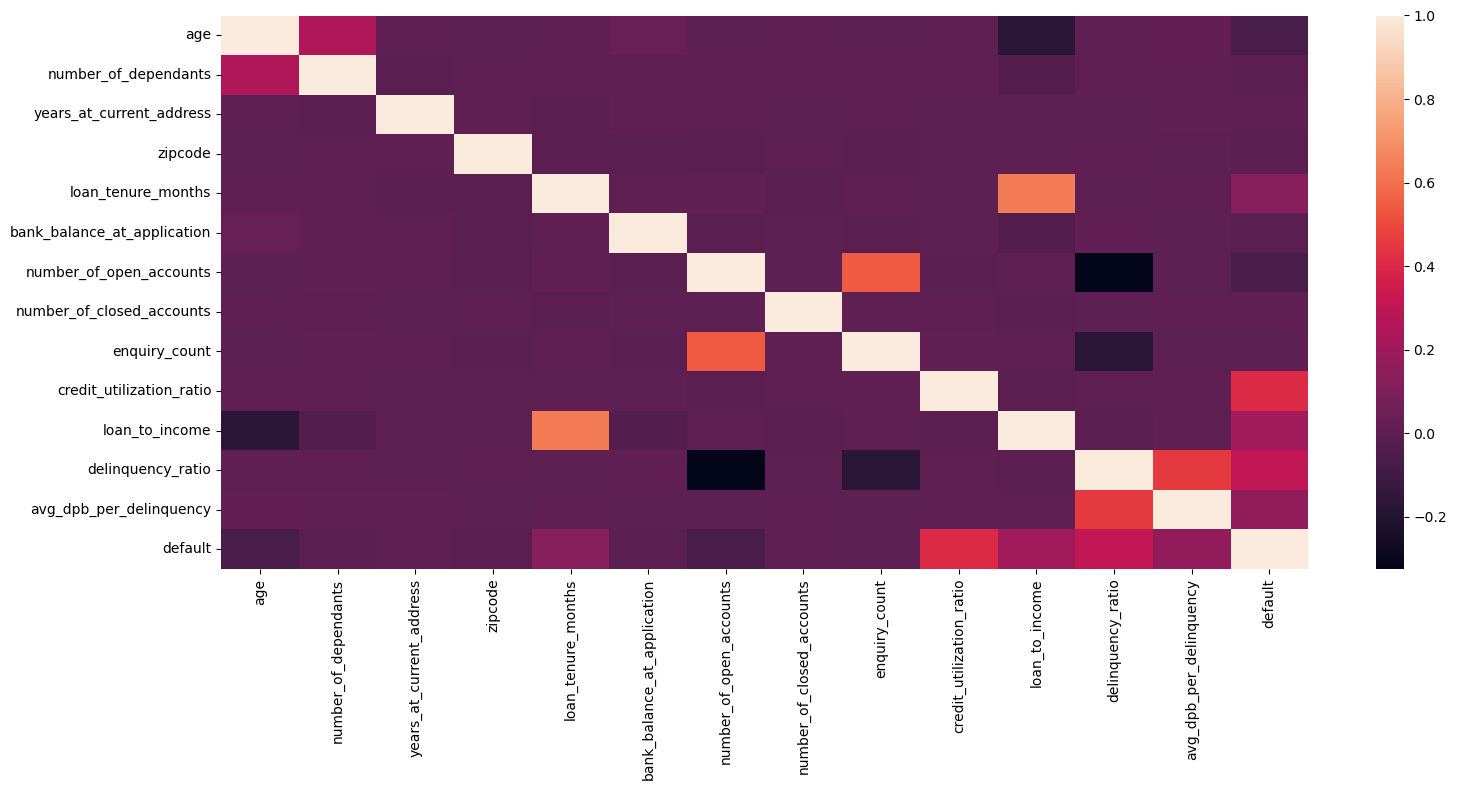

In [290]:
plt.figure(figsize=(16,8))
cm = df_train3[numerical_columns.append(pd.Index(['default']))].corr()
sns.heatmap(data = cm)
plt.xticks(rotation =90)

plt.tight_layout()
plt.show()


In [291]:
columns_categorical

# similar like VIF.
# for categorical features, "weight_of_Evidence" & "Information_gain" are 2 such methods,
# to find the influence of categorical features with target variable

['gender',
 'marital_status',
 'employment_status',
 'residence_type',
 'city',
 'state',
 'zipcode',
 'loan_purpose',
 'loan_type',
 'default']

In [292]:
# WoE --> ln(proportion_good /  proportion_bad)
# IV --> sum of (WoE * (proportion_good - proportion_bad))
# feature selection based on IV 
# --> IV < 0.02 very little predictive power
# --> IV = 0.02 to 0.1 Weak predictive power
# --> IV = 0.1 to 0.3 Medium
# --> IV < 0.3 to 0.5 strong
# --> IV >= 0.5 very strong

In [456]:
def calculate_woe_iv(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped = grouped.rename(columns = {'count' : 'total', 'sum': 'good'})
    grouped['bad'] = grouped['total'] - grouped['good']

    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()

    grouped['good_perc'] = grouped['good'] / total_good
    grouped['bad_perc'] = grouped['bad'] / total_bad

    grouped['woe'] = np.log(grouped['good_perc'] / grouped['bad_perc'] )
    grouped['iv'] = grouped['woe'] * (grouped['good_perc'] - grouped['bad_perc']) 

    grouped['woe'] = grouped['woe'].replace([np.inf, -np.inf],0)
    grouped['iv'] = grouped['iv'].replace([np.inf, -np.inf],0)

    iv = grouped['iv'].sum()
    
    return grouped, iv


# to apply woe we require target variable, 
# since we dont have target variable in X_train1, we have to concat with y_train & pull target variable for our analaysi

In [457]:
grouped, iv = calculate_woe_iv(pd.concat([X_train1, y_train], axis =1), 'delinquency_ratio', 'default')
grouped.sort_values(by = 'iv', ascending = False)

,total,good,bad,good_perc,bad_perc,woe,iv
delinquency_ratio,,,,,,,
0.0000,15013,469,14544,0.147068,0.424048,-1.058951,0.293308
1.0000,342,193,149,0.060521,0.004344,2.634124,0.147975
0.7500,70,35,35,0.010975,0.001020,2.375380,0.023646
0.6667,106,40,66,0.012543,0.001924,1.874604,0.019906
0.8000,43,22,21,0.006899,0.000612,2.421900,0.015225
...,...,...,...,...,...,...,...
0.1235,9,0,9,0.000000,0.000262,0.000000,0.000000
0.1233,13,0,13,0.000000,0.000379,0.000000,0.000000
0.1218,1,0,1,0.000000,0.000029,0.000000,0.000000


In [458]:
total_iv = grouped['iv'].sum()
total_iv

1.07135652121898

In [459]:
iv_values = {}

for features in X_train1.columns:
    if X_train1[features].dtype == 'object': # condition to filter only categorical values
        _, iv = calculate_woe_iv(pd.concat([X_train1, y_train], axis =1), features, 'default')
    else:
        X_binned = pd.cut(X_train1[features], bins = 10, labels=False) # condition to bin numerical features
        _, iv = calculate_woe_iv(pd.concat([X_train1, y_train], axis =1), features, 'default')
    iv_values[features] = iv
        
iv_values      

# output is a dict
# for categorical variables we got woe(weight of evidence) & iv (information value)
# convert into df

{'age': 0.08903203670903374,
 'gender': 0.000482276463421216,
 'marital_status': 0.002196681370832318,
 'employment_status': 0.002447818101774487,
 'number_of_dependants': 0.00364589452118596,
 'residence_type': 0.2594019617563985,
 'years_at_current_address': 0.007239704408847107,
 'city': 0.000817870465334103,
 'state': 0.0007881984519711978,
 'zipcode': 0.000817870465334103,
 'loan_purpose': 0.39377543144164784,
 'loan_type': 0.17304705897793143,
 'loan_tenure_months': 0.2924924995182448,
 'bank_balance_at_application': 0.03986096237814208,
 'number_of_open_accounts': 0.07324250836253295,
 'number_of_closed_accounts': 0.00026280824021760536,
 'enquiry_count': 0.005484982638303533,
 'credit_utilization_ratio': 2.5417455752693012,
 'loan_to_income': 0.6115344519830772,
 'delinquency_ratio': 1.07135652121898,
 'avg_dpb_per_delinquency': 0.44622018921443846}

In [460]:
iv_df = pd.DataFrame(list(iv_values.items()), columns=['features', 'iv'])
iv_df.sort_values(by = 'iv', ascending=False)

# feature selection based on IV 
# --> IV < 0.02 very little predictive power
# --> IV = 0.02 to 0.1 Weak predictive power
# --> IV = 0.1 to 0.3 Medium
# --> IV < 0.3 to 0.5 strong
# --> IV >= 0.5 very strong



,features,iv
17,credit_utilization_ratio,2.541746
19,delinquency_ratio,1.071357
18,loan_to_income,0.611534
20,avg_dpb_per_delinquency,0.446220
10,loan_purpose,0.393775
12,loan_tenure_months,0.292492
5,residence_type,0.259402
11,loan_type,0.173047
0,age,0.089032
14,number_of_open_accounts,0.073243


In [465]:
selected_features_df = iv_df[iv_df['iv'] > 0.02] # this is df
selected_features_iv = list(selected_features_df['features']) # these are feature_names in that df
selected_features_iv

['age',
 'residence_type',
 'loan_purpose',
 'loan_type',
 'loan_tenure_months',
 'bank_balance_at_application',
 'number_of_open_accounts',
 'credit_utilization_ratio',
 'loan_to_income',
 'delinquency_ratio',
 'avg_dpb_per_delinquency']

## 5.3 Feature Encoding 

In [469]:
X_train1.shape , X_train1[selected_features_iv].shape

# X_train1 --> before feature selection (21)
# X_train_reduced --> after feature selection (21 to 11) 

((37487, 21), (37487, 11))

In [470]:
X_train_reduced = X_train1[selected_features_iv]
X_test_reduced = X_test[selected_features_iv]

In [472]:
X_train_reduced.head()

,age,residence_type,loan_purpose,loan_type,loan_tenure_months,bank_balance_at_application,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpb_per_delinquency
27434,0.519231,Owned,Home,Secured,0.339623,0.069846,1.000000,0.595960,0.608899,0.0667,0.55
13400,0.211538,Owned,Auto,Secured,0.509434,0.119061,0.666667,0.929293,0.182670,0.0336,0.42
883,0.615385,Mortgage,Personal,Unsecured,0.245283,0.096133,0.333333,0.838384,0.084309,0.1687,0.56
7303,0.480769,Owned,Auto,Secured,0.283019,0.012511,0.000000,0.343434,0.187354,0.0000,0.00
45124,0.250000,Owned,Education,Secured,0.735849,0.006171,0.333333,0.191919,0.360656,0.0968,0.47


In [473]:
X_train_encoded = pd.get_dummies(data = X_train_reduced, drop_first=True)
X_test_encoded = pd.get_dummies(data = X_test_reduced, drop_first=True)


In [474]:
X_train_encoded.head()

,age,loan_tenure_months,bank_balance_at_application,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpb_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
27434,0.519231,0.339623,0.069846,1.000000,0.595960,0.608899,0.0667,0.55,True,False,False,True,False,False
13400,0.211538,0.509434,0.119061,0.666667,0.929293,0.182670,0.0336,0.42,True,False,False,False,False,False
883,0.615385,0.245283,0.096133,0.333333,0.838384,0.084309,0.1687,0.56,False,False,False,False,True,True
7303,0.480769,0.283019,0.012511,0.000000,0.343434,0.187354,0.0000,0.00,True,False,False,False,False,False
45124,0.250000,0.735849,0.006171,0.333333,0.191919,0.360656,0.0968,0.47,True,False,True,False,False,False


# 6. Model Training

## 6.1 First attempt
### logistic regression, Random Forest, XGB
### No handling of class imbalance

### 6.1.1 Logistic Regression

In [475]:
model_lr = LogisticRegression()
model_lr.fit(X_train_encoded, y_train)

y_pred_lr = model_lr.predict(X_test_encoded)

print(f"classification report for logistic regression: \n {classification_report(y_test, y_pred_lr)}")

# 0 --> not default
# 1 --> default
# we can clearly observed that precision & recall for class 0/not_default is great compared with class 1/default
# class 1/default precision > recall 
# for credit risk model we make sure "recall" should be best, which means (we want to catch individuals likely to default)

classification report for logistic regression: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     11390
           1       0.83      0.69      0.76      1108

    accuracy                           0.96     12498
   macro avg       0.90      0.84      0.87     12498
weighted avg       0.96      0.96      0.96     12498



### 6.1.2 Random forest

In [477]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_encoded, y_train)

y_pred_rf = model_rf.predict(X_test_encoded)

print(f"classification report for Random Forest: \n {classification_report(y_test, y_pred_rf)}")

# kind of same, no increase of recall for class1

classification report for Random Forest: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     11390
           1       0.85      0.69      0.76      1108

    accuracy                           0.96     12498
   macro avg       0.91      0.84      0.87     12498
weighted avg       0.96      0.96      0.96     12498



### 6.1.3 XG Boost

In [480]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_encoded, y_train)

y_pred_xgb = model_xgb.predict(X_test_encoded)

print(f"classification report for XG Boost: \n {classification_report(y_test, y_pred_xgb)}")

# little bit of improvement in recall compared with 2 other models

classification report for XG Boost: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     11390
           1       0.82      0.74      0.78      1108

    accuracy                           0.96     12498
   macro avg       0.90      0.86      0.88     12498
weighted avg       0.96      0.96      0.96     12498



### 6.1.4 Randomized SearchCV wth logistic regression

In [488]:
lr = LogisticRegression(max_iter = 10000)

param_dis = {
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs','saga', 'liblinear', 'newton-cg']
}

model_rs_cv = RandomizedSearchCV(
                                estimator = lr,  # algo used 
                                param_distributions = param_dis, # diff parameters & solvers
                                n_iter=50,
                                scoring='f1',
                                cv=3,
                                verbose=2,
                                random_state=42,
                                n_jobs= 1
                            )

model_rs_cv.fit(X_train_encoded, y_train) # model training 


best_model = model_rs_cv.best_estimator_ # best estimator for given slover

print(f"best parameters : {model_rs_cv.best_params_}") # best parameter from given C

print(f"best score : {model_rs_cv.best_score_}") # takes best score for a solver & parameter


y_pred_rs_cv = best_model.predict(X_test_encoded)
print(f"classification report based on Randomized SearchCV \n: {classification_report(y_test, y_pred_rs_cv)}")

# not much improvement compared with 3 other models
# my recall not improved 

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ............C=0.08858667904100823, solver=liblinear; total time=   0.0s
[CV] END ............C=0.08858667904100823, solver=liblinear; total time=   0.0s
[CV] END ............C=0.08858667904100823, solver=liblinear; total time=   0.0s
[CV] END .............................C=0.0001, solver=lbfgs; total time=   0.0s
[CV] END .............................C=0.0001, solver=lbfgs; total time=   0.0s
[CV] END .............................C=0.0001, solver=lbfgs; total time=   0.0s
[CV] END ...........C=0.012742749857031334, solver=liblinear; total time=   0.0s
[CV] END ...........C=0.012742749857031334, solver=liblinear; total time=   0.0s
[CV] END ...........C=0.012742749857031334, solver=liblinear; total time=   0.0s
[CV] END ............C=0.08858667904100823, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.08858667904100823, solver=newton-cg; total time=   0.1s
[CV] END ............C=0.08858667904100823, sol

### 6.1.5 Randomized SearchCV wth XG Boost

In [495]:
xgb = XGBClassifier()

param_dis = {
       'n_estimators' : [100,150,200,250,300],
        'max_depth' : [3,4,5,6,7,8,9,10],
        'learning_rate': [0.01,0.03,0.05,0.1,0.15,0.2,0.25,0.3],
        'subsample': [0.6,0.7,0.8,0.9,1.0],
        'colsample_bytree' : [0.6,0.7,0.8,0.9,1.0],
        'scale_pos_weight' : [1,2,3,5,7,10],
        'reg_alpha' : [0.01,0.1,0.5,1.0,5.0,10.0], # L1 regression
        'reg_lambda' : [0.01,0.1,0.5,1.0,5.0,10.0] # L2 regression
}

model_rs_xgb = RandomizedSearchCV(
                                estimator = xgb,  # algo used 
                                param_distributions = param_dis, # diff parameters & solvers
                                n_iter=100,
                                scoring='f1',
                                cv=3,
                                verbose=2,
                                random_state=42,
                                n_jobs= 1
                            )

model_rs_xgb.fit(X_train_encoded, y_train) # model training 


best_model = model_rs_xgb.best_estimator_ # best estimator for given slover

print(f"best parameters : {model_rs_xgb.best_params_}") # best parameter from given C

print(f"best score : {model_rs_xgb.best_score_}") # takes best score for a solver & parameter


y_pred_rs_xgb = best_model.predict(X_test_encoded)
print(f"classification report based on Randomized SearchCV \n: {classification_report(y_test, y_pred_rs_xgb)}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=10.0, reg_lambda=1.0, scale_pos_weight=2, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=10.0, reg_lambda=1.0, scale_pos_weight=2, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=10.0, reg_lambda=1.0, scale_pos_weight=2, subsample=0.9; total time=   3.9s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, reg_alpha=0.5, reg_lambda=1.0, scale_pos_weight=10, subsample=0.6; total time=   5.5s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, reg_alpha=0.5, reg_lambda=1.0, scale_pos_weight=10, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, reg_alpha=0.5, reg

## 6.2 Second attempt
### logistic regression, XGB
### Handle Class imbalance using Under sampling techniques

In [498]:
y_train.value_counts()

# clear class imbalance this is treated with under/over sampling techniques

default
0    34298
1     3189
Name: count, dtype: int64

## 6.2.1 Random under sampling

In [497]:
from imblearn.under_sampling import RandomUnderSampler

model_rus = RandomUnderSampler(random_state = 42)
X_train_rus, y_train_rus = model_rus.fit_resample(X_train_encoded, y_train)

In [499]:
y_train_rus.value_counts()

# since we are using undersampling technique
# it samples data to match with minority class by reducing records of majority class

default
0    3189
1    3189
Name: count, dtype: int64

## 6.2.2 RUS using Logistic Regression

In [500]:
model_lr_rus = LogisticRegression()
model_lr_rus.fit(X_train_rus, y_train_rus)

y_pred_lr_rus = model_lr_rus.predict(X_test_encoded)

print(f"classification report for logistic regression undersampling: \n {classification_report(y_test, y_pred_lr_rus)}")

# our recall increased significatly for defalut class (1), but precision got suffered
# 

classification report for logistic regression undersampling: 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     11390
           1       0.53      0.95      0.68      1108

    accuracy                           0.92     12498
   macro avg       0.76      0.93      0.82     12498
weighted avg       0.95      0.92      0.93     12498



## 6.2.2 RUS using XG Boost

In [501]:
model_xgb_rus = XGBClassifier(**model_rs_xgb.best_params_)
model_xgb_rus.fit(X_train_rus, y_train_rus)

y_pred_xgb_rus = model_xgb_rus.predict(X_test_encoded)

print(f"classification report for logistic regression undersampling: \n {classification_report(y_test, y_pred_xgb_rus)}")

# recall increased significatly compared with RUS_logistic_regression

classification report for logistic regression undersampling: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     11390
           1       0.52      0.98      0.68      1108

    accuracy                           0.92     12498
   macro avg       0.76      0.95      0.82     12498
weighted avg       0.96      0.92      0.93     12498



## 6.3 Third attempt
### logistic regression, XGB
### Handle Class imbalance using Over sampling techniques

In [503]:
y_train.value_counts()

# before oversampling

default
0    34298
1     3189
Name: count, dtype: int64

In [502]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

model_smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = model_smt.fit_resample(X_train_encoded, y_train)

In [505]:
y_train_smt.value_counts()

# After oversampling
# oversampling will add synthenic data to minority class, equvating minority class to majority class 

default
0    34244
1    34244
Name: count, dtype: int64

In [506]:
model_lr_smt = LogisticRegression()
model_lr_smt.fit(X_train_smt, y_train_smt)

y_pred_lr_smt = model_lr_smt.predict(X_test_encoded)

print(f"classification report for logistic regression oversampling: \n {classification_report(y_test, y_pred_lr_smt)}")



classification report for logistic regression oversampling: 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     11390
           1       0.57      0.94      0.71      1108

    accuracy                           0.93     12498
   macro avg       0.78      0.93      0.83     12498
weighted avg       0.96      0.93      0.94     12498

